## Dataset Background

What can we say about the success of a movie before it is released? Are there certain companies (Pixar?) that have found a consistent formula? Given that major films costing over $100 million to produce can still flop, this question is more important than ever to the industry. Film aficionados might have different interests. Can we predict which films will be highly rated, whether or not they are a commercial success?

This is a great place to start digging in to those questions, with data on the plot, cast, crew, budget, and revenues of several thousand films.

---

### Dataset Description

#### First Dataset: tmdb_5000_credits.csv
- **movie_id**: A unique identifier for each movie.
- **cast**: The name of lead and supporting actors.
- **crew**: The name of Director, Editor, Composer, Writer etc.

#### Second Dataset: tmdb_5000_movies.csv
- **budget**: The budget in which the movie was made.
- **genre**: The genre of the movie, Action, Comedy, Thriller etc.
- **homepage**: A link to the homepage of the movie.
- **id**: This is in fact the movie_id as in the first dataset.
- **keywords**: The keywords or tags related to the movie.
- **original_language**: The language in which the movie was made.
- **original_title**: The title of the movie before translation or adaptation.
- **overview**: A brief description of the movie.
- **popularity**: A numeric quantity specifying the movie popularity.
- **production_companies**: The production house of the movie.
- **production_countries**: The country in which it was produced.
- **release_date**: The date on which it was released.
- **revenue**: The worldwide revenue generated by the movie.
- **runtime**: The running time of the movie in minutes.
- **status**: "Released" or "Rumored".
- **tagline**: Movie's tagline.
- **title**: Title of the movie.
- **vote_average**: Average ratings the movie received.
- **vote_count**: The count of votes received.


In [7]:
# import libraries
import json
import warnings
from datetime import datetime
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 70)

In [9]:
def count_nan_values(dataframe, column_name):
    nan_count = dataframe[column_name].isna().sum()
    print(f"Number of NaN values in '{column_name}': {nan_count}")

## Data Preparation Functions

In this section, we define a series of functions to create an interface with the new structure of the dataset. The following functions are adapted from Sohier's kernel:

- **`load_tmdb_movies(path)`:** This function loads the TMDb movies dataset from the specified path. It converts the 'release_date' column to datetime format and applies JSON parsing to columns such as 'genres', 'keywords', 'production_countries', 'production_companies', and 'spoken_languages'.

- **`load_tmdb_credits(path)`:** This function loads the TMDb credits dataset from the specified path. Similar to `load_tmdb_movies()`, it applies JSON parsing to columns such as 'cast' and 'crew'.

We also define some mappings and utility functions:

- **Lost Columns:** A list of columns that existed in the IMDB version of the dataset but are no longer present.

- **TMDB to IMDB Simple Equivalences:** A mapping between columns in TMDb and their equivalents in the IMDB version.

- **IMDB Columns to Remap:** A mapping to rename columns from IMDB format to TMDb format.

- **`safe_access(container, index_values)`:** A utility function that returns a missing value rather than an error upon indexing/key failure.

- **`get_director(crew_data)`:** This function extracts the director's name from the crew data.

- **`pipe_flatten_names(keywords)`:** A utility function to flatten keywords.

- **`convert_to_original_format(movies, credits)`:** This function converts TMDb data to make it as compatible as possible with kernels built on the original version of the data. It renames columns, extracts year from the release date, retrieves the first production country and language, extracts director and actor names, and flattens genres and plot keywords.

We then load the TMDb movies and credits datasets and convert them to the original format using the defined functions.


In [10]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df


def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [11]:
# Columns that existed in the IMDB version of the dataset and are gone.
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews'
                ]

In [12]:
# Columns in TMDb that had direct equivalents in the IMDB version. 
# These columns can be used with old kernels just by changing the names
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  # it's possible that spoken_languages would be a better match
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users',
                                         }

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}

In [13]:
def safe_access(container, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return np.nan


def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])

def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])


def convert_to_original_format(movies, credits):
    # Converts TMDb data to make it as compatible as possible with kernels built on the original version of the data.
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [14]:
movies = load_tmdb_movies("tmdb_5000_movies.csv")
credits = load_tmdb_credits("tmdb_5000_credits.csv")
main_df = convert_to_original_format(movies, credits)

In [15]:
main_df.head()

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,James Cameron,Sam Worthington,Zoe Saldana,Sigourney Weaver
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Gore Verbinski,Johnny Depp,Orlando Bloom,Keira Knightley
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,2015.0,United Kingdom,Sam Mendes,Daniel Craig,Christoph Waltz,Léa Seydoux
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,United States of America,Christopher Nolan,Christian Bale,Michael Caine,Gary Oldman
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,United States of America,Andrew Stanton,Taylor Kitsch,Lynn Collins,Samantha Morton


In [16]:
main_df.to_csv('data.csv', index=False)

### New Dataset Overview

In this section, we provide an overview of the features included in the new dataset. Each feature provides valuable information about the movies contained in the dataset:

1. **budget:** The budget allocated for producing the movie.
2. **genres:** The genre(s) to which the movie belongs.
3. **homepage:** The URL of the movie's official website, if available.
4. **id:** Unique identifier for each movie in the dataset.
5. **plot_keywords:** Keywords describing the plot or themes of the movie.
6. **language:** The language(s) in which the movie is primarily spoken.
7. **original_title:** The original title of the movie.
8. **overview:** A brief summary or description of the movie.
9. **popularity:** Popularity score of the movie.
10. **production_companies:** Companies involved in producing the movie.
11. **production_countries:** Countries where the movie was produced.
12. **release_date:** The date when the movie was released.
13. **gross:** The gross revenue generated by the movie.
14. **duration:** The duration or length of the movie.
15. **spoken_languages:** Languages spoken in the movie.
16. **status:** The status of the movie (e.g., released, in production).
17. **tagline:** A memorable phrase or slogan associated with the movie.
18. **movie_title:** The title of the movie.
19. **vote_average:** The average rating given to the movie by users.
20. **num_voted_users:** The number of users who voted/rated the movie.
21. **title_year:** The year when the movie was released.
22. **country:** The country where the movie was primarily produced.
23. **director_name:** The name of the movie's director.
24. **actor_1_name:** The name of the primary actor in the movie.
25. **actor_2_name:** The name of the secondary actor in the movie.
26. **actor_3_name:** The name of another actor in the movie.

These features collectively provide a comprehensive overview of each movie, including its production details, cast, crew, and user ratings.


## Data Cleaning and Preprocessing

In this section, we perform essential data cleaning and preprocessing tasks to ensure the dataset is ready for analysis and modeling.

### Check for Duplicates

We start by checking for duplicate entries in the dataset. Duplicates can skew analysis results and lead to erroneous conclusions. By specifying the columns to check for duplicates and counting the number of duplicate entries, we ensure the integrity of our dataset.


In [17]:
df_preprocessed = main_df.copy()

In [18]:
# Specify columns to check for duplicate
columns_to_check = ['id', 'original_title']

# Check for duplicates
duplicates = df_preprocessed.duplicated(subset=columns_to_check)

# Count the number of duplicates
num_duplicates = duplicates.sum()

# Display the duplicates
if num_duplicates > 0:
    print("Number of duplicates found:", num_duplicates)
    print(df_preprocessed[duplicates])
else:
    print("No duplicates found.")


No duplicates found.


### Remove Extra Columns

Next, we remove extraneous columns from the dataset. These columns, such as 'homepage', 'id', 'spoken_languages', 'status', 'movie_title', and 'title_year', may not contribute significantly to our analysis or modeling tasks. Removing them streamlines the dataset and focuses on the most relevant features, making subsequent analysis more efficient and effective.

These data cleaning and preprocessing steps are crucial for ensuring the quality and integrity of our dataset, setting the stage for meaningful analysis and insights.

In [13]:
columns_to_drop = ['homepage', 'id', 'spoken_languages', 'status', 'movie_title', 'title_year']
df_preprocessed.drop(columns_to_drop, axis=1, inplace=True)

In [14]:
df_preprocessed.head()

,budget,genres,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,tagline,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,Enter the World of Pandora.,7.2,11800,United States of America,James Cameron,Sam Worthington,Zoe Saldana,Sigourney Weaver
1,300000000,Adventure|Fantasy|Action,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"At the end of the world, the adventure begins.",6.9,4500,United States of America,Gore Verbinski,Johnny Depp,Orlando Bloom,Keira Knightley
2,245000000,Action|Adventure|Crime,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,A Plan No One Escapes,6.3,4466,United Kingdom,Sam Mendes,Daniel Craig,Christoph Waltz,Léa Seydoux
3,250000000,Action|Crime|Drama|Thriller,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,The Legend Ends,7.6,9106,United States of America,Christopher Nolan,Christian Bale,Michael Caine,Gary Oldman
4,260000000,Action|Adventure|Science Fiction,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"Lost in our world, found in another.",6.1,2124,United States of America,Andrew Stanton,Taylor Kitsch,Lynn Collins,Samantha Morton


### Feature-wise Data Cleaning and Preprocessing

In this section, we systematically examine each feature in the dataset, addressing any data quality issues and performing necessary preprocessing steps to ensure the dataset's integrity and suitability for analysis. Each feature undergoes thorough scrutiny and cleaning to enhance the overall quality of the dataset.


### Budget and Gross Preprocessing

#### 1. Reducing Digits for Better Readability
- The numbers in the 'budget' and 'gross' columns are too large, compromising readability. We convert the units of these columns from dollars to million dollars for better comprehension.

#### 2. Checking for Missing Values
- We check for missing values in both the 'budget' and 'gross' columns. If any missing values are found, appropriate actions can be taken to handle them.

#### 3. Checking for Negative Values
- We verify if there are any negative values in the 'budget' and 'gross' columns. Negative values in these columns would be erroneous and need to be addressed.

#### 4. Visualizing Outliers
- We use boxplots to visualize outliers in the 'budget' and 'gross' columns. This helps identify extreme values that may skew analysis results.

#### 5. Handling Zero Budget Entries
- We count the number of entries where the budget is equal to 0. If some entries have a budget of 0 but a non-zero gross, it could be due to various reasons, such as missing data or low-budget films.

#### 6. Categorizing Budget
- We categorize the budget into 'low', 'average', and 'high' based on quartile thresholds. This categorization provides insights into the distribution of budget values across the dataset.

These preprocessing steps ensure that the 'budget' and 'gross' features are cleaned and prepared for further analysis.


In [15]:
df_preprocessed[['budget', 'gross']]

,budget,gross
0,237000000,2787965087
1,300000000,961000000
2,245000000,880674609
3,250000000,1084939099
4,260000000,284139100
...,...,...
4798,220000,2040920
4799,9000,0
4800,0,0
4801,0,0


#### Reducing digits for better readability

The numbers in the budget and gross are too big, compromising its readability. Let's convert the unit of the budget and gross columns from dollor to million dollor first.

In [16]:
# Convert budget and gross columns to million dollars
df_preprocessed['budget'] = main_df['budget'] / 1000000
df_preprocessed['gross'] = main_df['gross'] / 1000000

# Print the first few rows to verify the conversion
df_preprocessed[['budget', 'gross']].tail()

,budget,gross
4798,0.220,2.04092
4799,0.009,0.00000
4800,0.000,0.00000
4801,0.000,0.00000
4802,0.000,0.00000


#### Check for missing values in the 'budget' column

In [17]:
# Check for missing values in the 'budget' column
missing_values = main_df['budget'].isnull().sum()

if missing_values > 0:
    print("There are", missing_values, "missing values in the 'budget' column.")
else:
    print("There are no missing values in the 'budget' column.")

There are no missing values in the 'budget' column.


In [18]:
# Check for missing values in the 'gross' column
missing_values = main_df['gross'].isnull().sum()

if missing_values > 0:
    print("There are", missing_values, "missing values in the 'gross' column.")
else:
    print("There are no missing values in the 'gross' column.")

There are no missing values in the 'gross' column.


#### Check for negative values in the 'budget' column

In [19]:
# Check for negative values in the 'budget' column
negative_budget = (df_preprocessed['budget'] < 0).sum()

if negative_budget > 0:
    print("There are", negative_budget, "negative values in the 'budget' column.")
else:
    print("There are no negative values in the 'budget' column.")


There are no negative values in the 'budget' column.


#### Check for negative values in the 'gross' column

In [20]:
# Check for negative values in the 'budget' column
negative_budget = (df_preprocessed['gross'] < 0).sum()

if negative_budget > 0:
    print("There are", negative_budget, "negative values in the 'gross' column.")
else:
    print("There are no negative values in the 'gross' column.")


There are no negative values in the 'gross' column.


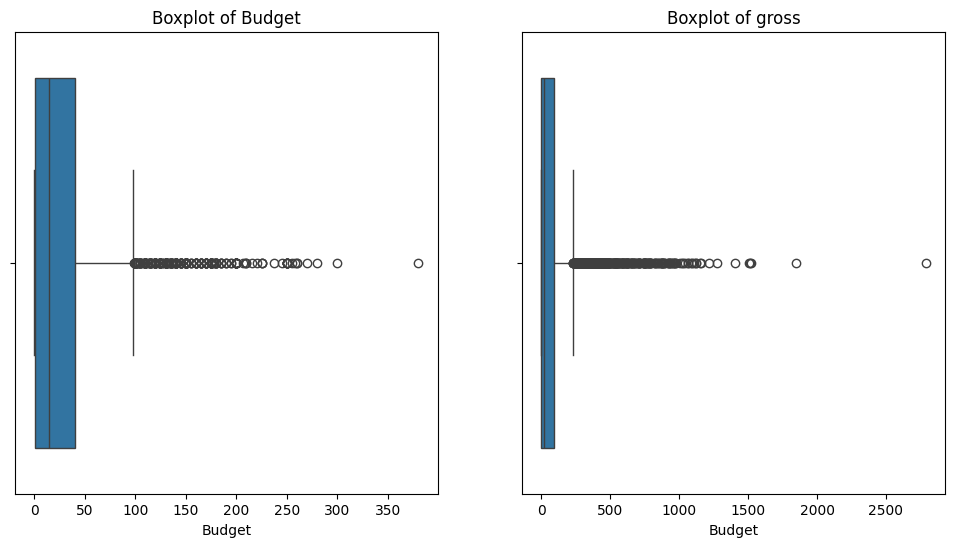

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot boxplot to visualize outliers in the 'budget' column
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)

sns.boxplot(x=df_preprocessed['budget'])
plt.title('Boxplot of Budget')
plt.xlabel('Budget')


plt.subplot(1,2,2)

sns.boxplot(x=df_preprocessed['gross'])
plt.title('Boxplot of gross')
plt.xlabel('Budget')
plt.show()

In [24]:
# Count the number of entries where budget is equal to 0
num_zero_budget = (main_df['budget'] == 0).sum()

print("Number of entries where budget is equal to 0:", num_zero_budget)


Number of entries where budget is equal to 0: 1037


In [26]:
# Count the number of entries where budget is equal to 0
num_zero_gross = (df_zero_budget['gross'] == 0).sum()

print("Number of entries where gross is equal to 0:", num_zero_gross)

Number of entries where gross is equal to 0: 890


In [22]:
# Define quartile thresholds for categorization
low_threshold = df_preprocessed['budget'].quantile(0.25)
high_threshold = df_preprocessed['budget'].quantile(0.75)

# Categorize budget
df_preprocessed['budget_categorized'] = np.where(df_preprocessed['budget'] < low_threshold, 'low',
                                    np.where(df_preprocessed['budget'] <= high_threshold, 'average', 'high'))

# Display the DataFrame with the new column
df_preprocessed['budget_categorized'].value_counts()


budget_categorized
average    2487
low        1201
high       1115
Name: count, dtype: int64

If some entries have a budget of 0 but a non-zero gross, it could be due to various reasons:

1. **Missing or Incomplete Data:** Sometimes, budget data might be missing or incomplete, leading to a value of 0. However, the movie could still generate revenue, resulting in a non-zero gross.

2. **Low-budget or Independent Films:** Some low-budget or independent films might have minimal or no budget recorded, especially if they are self-funded or financed through alternative means. However, these films can still generate revenue through ticket sales, distribution deals, or other sources.


### Creating Profit Column

#### 1. Making Profit Column
- We calculate the profit by subtracting the 'budget' from the 'gross'. This newly created 'profit' column represents the financial gain or loss generated by each movie.

#### 2. Categorizing Profit
- To categorize the profit, we calculate 10% of the budget as a threshold. If the profit exceeds this threshold, we categorize it as 'profit'; otherwise, it is labeled as 'no profit'.

These steps help us categorize the profitability of each movie, providing insights into its financial performance.


In [19]:
# make profit column
df_preprocessed['profit'] = df_preprocessed['gross'] - df_preprocessed['budget']

In [20]:
# Calculate 10% of the budget
threshold = 0.1 * df_preprocessed['budget']

# Categorize profit
df_preprocessed['profit_categorized'] = np.where(df_preprocessed['profit'] > threshold, 'profit', 'no profit')

In [21]:
df_preprocessed['profit_categorized'].value_counts()

profit_categorized
profit       2515
no profit    2288
Name: count, dtype: int64

### Genres Preprocessing

#### Encoding Genres
1. **Splitting Genre Strings:** We split the genre strings in the 'genres' column into lists of genres using the '|' separator.

2. **Unique Genres:** We create a list of all unique genres present in the dataset by flattening the list of lists obtained from the previous step.

3. **MultiLabelBinarizer Encoding:** Using scikit-learn's MultiLabelBinarizer, we encode the genre lists into a binary format, where each genre corresponds to a binary column indicating its presence in a movie.

4. **Adding Encoded Genres to DataFrame:** We concatenate the encoded genres DataFrame with the original DataFrame, adding binary columns for each genre.

#### Handling Other Genres
5. **Identifying Other Genres:** We identify genres with counts below a specified threshold (e.g., 200) as "other" genres.

6. **Creating 'Other' Column:** We create a new column, 'other', to indicate whether a movie belongs to one of the "other" genres.

#### Cleaning Genre Columns
7. **Removing Columns for "Other Genres":** We remove columns corresponding to genres identified as "other" genres from the dataset.

8. **Converting Genre Types to Boolean:** We iterate over the list of unique genres and convert the type of each genre column to boolean if it's not included in the list of "other" genres. This ensures consistent data representation for genres across the dataset.

These preprocessing steps ensure that the 'genres' feature is appropriately encoded and cleaned for further analysis or modeling.


In [23]:
main_df['genres']

0       Action|Adventure|Fantasy|Science Fiction
1                       Adventure|Fantasy|Action
2                         Action|Adventure|Crime
3                    Action|Crime|Drama|Thriller
4               Action|Adventure|Science Fiction
                          ...                   
4798                       Action|Crime|Thriller
4799                              Comedy|Romance
4800               Comedy|Drama|Romance|TV Movie
4801                                            
4802                                 Documentary
Name: genres, Length: 4803, dtype: object

In [24]:
from sklearn.preprocessing import MultiLabelBinarizer

In [25]:
# Split the genre strings into lists of genres
genres_list = df_preprocessed['genres'].str.split('|').tolist()

# Flatten the list of lists into a single list
all_genres = [genre for sublist in genres_list for genre in sublist]

# Get unique genres
unique_genres = list(set(all_genres))

print("List of all genres in the DataFrame:")
print(unique_genres)

List of all genres in the DataFrame:
['', 'Mystery', 'Science Fiction', 'Music', 'Drama', 'Romance', 'Animation', 'Adventure', 'Action', 'Foreign', 'War', 'Comedy', 'Fantasy', 'Documentary', 'Thriller', 'Horror', 'TV Movie', 'History', 'Western', 'Family', 'Crime']


In [26]:
genres_str = main_df['genres']

# Split the genres string into lists of genres
genres_split = genres_str.str.split('|')

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the genres
genres_encoded = mlb.fit_transform(genres_split)

# Convert the encoded genres into a DataFrame for easier manipulation
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

# Concatenate the encoded genres DataFrame with your original DataFrame
df_preprocessed = pd.concat([df_preprocessed, genres_df], axis=1)

In [27]:
df_preprocessed.head()

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name,profit,profit_categorized,,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,James Cameron,Sam Worthington,Zoe Saldana,Sigourney Weaver,2550965087,profit,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Gore Verbinski,Johnny Depp,Orlando Bloom,Keira Knightley,661000000,profit,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,2015.0,United Kingdom,Sam Mendes,Daniel Craig,Christoph Waltz,Léa Seydoux,635674609,profit,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,United States of America,Christopher Nolan,Christian Bale,Michael Caine,Gary Oldman,834939099,profit,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,United States of America,Andrew Stanton,Taylor Kitsch,Lynn Collins,Samantha Morton,24139100,no profit,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [28]:
genre_counts = genres_df.sum()

# Print the count of each genre
for genre, count in zip(genres_df.columns, genre_counts):
    print(f"{genre}: {count}")

: 28
Action: 1154
Adventure: 790
Animation: 234
Comedy: 1722
Crime: 696
Documentary: 110
Drama: 2297
Family: 513
Fantasy: 424
Foreign: 34
History: 197
Horror: 519
Music: 185
Mystery: 348
Romance: 894
Science Fiction: 535
TV Movie: 8
Thriller: 1274
War: 144
Western: 82


In [29]:
# Identify genres with counts below the threshold
threshold = 200
other_genres = genre_counts[genre_counts < threshold].index

# Define a function to check if a movie belongs to one of the "other" genres
def is_other_genre(row):
    for genre in other_genres:
        if row[genre] == 1:
            return 1
    return 0

# Iterate over each row of the DataFrame
for index, row in df_preprocessed.iterrows():
    # Apply the function to the current row to identify "other" genres
    result = is_other_genre(row)
    
    # Print the result for the current row
    print(f"Result for row {index}: {result}")
    
    # Assign the result to a new column 'other' in the DataFrame
    df_preprocessed.at[index, 'other'] = result

    
df_preprocessed['other'] = df_preprocessed['other'].astype(int)

Result for row 0: 0
Result for row 1: 0
Result for row 2: 0
Result for row 3: 0
Result for row 4: 0
Result for row 5: 0
Result for row 6: 0
Result for row 7: 0
Result for row 8: 0
Result for row 9: 0
Result for row 10: 0
Result for row 11: 0
Result for row 12: 0
Result for row 13: 1
Result for row 14: 0
Result for row 15: 0
Result for row 16: 0
Result for row 17: 0
Result for row 18: 0
Result for row 19: 0
Result for row 20: 0
Result for row 21: 0
Result for row 22: 0
Result for row 23: 0
Result for row 24: 0
Result for row 25: 0
Result for row 26: 0
Result for row 27: 0
Result for row 28: 0
Result for row 29: 0
Result for row 30: 0
Result for row 31: 0
Result for row 32: 0
Result for row 33: 0
Result for row 34: 0
Result for row 35: 0
Result for row 36: 0
Result for row 37: 0
Result for row 38: 0
Result for row 39: 0
Result for row 40: 0
Result for row 41: 0
Result for row 42: 0
Result for row 43: 0
Result for row 44: 0
Result for row 45: 0
Result for row 46: 0
Result for row 47: 0
Re

Result for row 1507: 0
Result for row 1508: 0
Result for row 1509: 0
Result for row 1510: 0
Result for row 1511: 0
Result for row 1512: 0
Result for row 1513: 0
Result for row 1514: 1
Result for row 1515: 0
Result for row 1516: 0
Result for row 1517: 0
Result for row 1518: 0
Result for row 1519: 0
Result for row 1520: 0
Result for row 1521: 1
Result for row 1522: 0
Result for row 1523: 1
Result for row 1524: 0
Result for row 1525: 1
Result for row 1526: 0
Result for row 1527: 1
Result for row 1528: 0
Result for row 1529: 0
Result for row 1530: 0
Result for row 1531: 0
Result for row 1532: 0
Result for row 1533: 0
Result for row 1534: 0
Result for row 1535: 0
Result for row 1536: 0
Result for row 1537: 0
Result for row 1538: 1
Result for row 1539: 0
Result for row 1540: 0
Result for row 1541: 0
Result for row 1542: 0
Result for row 1543: 0
Result for row 1544: 0
Result for row 1545: 0
Result for row 1546: 0
Result for row 1547: 0
Result for row 1548: 0
Result for row 1549: 0
Result for 

Result for row 3219: 0
Result for row 3220: 0
Result for row 3221: 1
Result for row 3222: 0
Result for row 3223: 0
Result for row 3224: 0
Result for row 3225: 0
Result for row 3226: 1
Result for row 3227: 1
Result for row 3228: 0
Result for row 3229: 1
Result for row 3230: 1
Result for row 3231: 0
Result for row 3232: 0
Result for row 3233: 0
Result for row 3234: 0
Result for row 3235: 0
Result for row 3236: 1
Result for row 3237: 0
Result for row 3238: 0
Result for row 3239: 0
Result for row 3240: 0
Result for row 3241: 0
Result for row 3242: 0
Result for row 3243: 0
Result for row 3244: 0
Result for row 3245: 0
Result for row 3246: 0
Result for row 3247: 0
Result for row 3248: 0
Result for row 3249: 0
Result for row 3250: 0
Result for row 3251: 0
Result for row 3252: 0
Result for row 3253: 0
Result for row 3254: 0
Result for row 3255: 0
Result for row 3256: 0
Result for row 3257: 0
Result for row 3258: 0
Result for row 3259: 0
Result for row 3260: 0
Result for row 3261: 0
Result for 

In [30]:
df_preprocessed.tail(10)

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name,profit,profit_categorized,,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,other
4793,0,Drama,NaN,182291,confession|hazing|gang member|latino|lgbt|cath...,NaN,On The Downlow,Isaac and Angel are two young Latinos involved...,0.029757,"[{'name': 'Iconoclast Films', 'id': 26677}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-04-11,0,90.0,[],Released,Two gangs. One secret. One crossroad.,On The Downlow,6.0,2,2004.0,United States of America,Tadeo Garcia,Tony Sancho,Michael Cortez,Donato Cruz,0,no profit,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4794,0,Thriller|Horror|Comedy,NaN,286939,,English,Sanctuary: Quite a Conundrum,"It should have been just a normal day of sex, ...",0.166513,"[{'name': 'Gold Lion Films', 'id': 37870}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-01-20,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Sanctuary: Quite a Conundrum,0.0,0,2012.0,United States of America,Thomas L. Phillips,Sasha Ramos,Erin Cline,Emily Rogers,0,no profit,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4795,0,Drama,NaN,124606,gang|audition|police fake|homeless|actress,English,Bang,A young woman in L.A. is having a bad day: she...,0.918116,"[{'name': 'Asylum Films', 'id': 10571}, {'name...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-09-09,0,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Sometimes you've got to break the rules,Bang,6.0,1,1995.0,United States of America,Ash Baron-Cohen,Darling Narita,Peter Greene,Michael Newland,0,no profit,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4796,7000,Science Fiction|Drama|Thriller,http://www.primermovie.com,14337,distrust|garage|identity crisis|time travel|ti...,English,Primer,Friends/fledgling entrepreneurs invent a devic...,23.307949,"[{'name': 'Thinkfilm', 'id': 446}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-10-08,424760,77.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,What happens if it actually works?,Primer,6.9,658,2004.0,United States of America,Shane Carruth,Shane Carruth,David Sullivan,Casey Gooden,417760,profit,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4797,0,Foreign|Thriller,NaN,67238,,NaN,Cavite,"Adam, a security guard, travels from Californi...",0.022173,[],[],2005-03-12,0,80.0,[],Released,NaN,Cavite,7.5,2,2005.0,NaN,Neill Dela Llana,NaN,NaN,NaN,0,no profit,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
4798,220000,Action|Crime|Thriller,NaN,9367,united states–mexico barrier|legs|arms|paper k...,Español,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{'name': 'Columbia Pictures', 'id': 5}]","[{'iso_3166_1': 'MX', 'name': 'Mexico'}, {'iso...",1992-09-04,2040920,81.0,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,1992.0,Mexico,Robert Rodriguez,Carlos Gallardo,Jaime de Hoyos,Peter Marquardt,1820920,profit,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4799,9000,Comedy|Romance,NaN,72766,,NaN,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,2011.0,NaN,Edward Burns,Edward Burns,Kerry Bishé,Marsha Dietlein,-9000,no profit,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4800,0,Comedy|Drama|Romance|TV Movie,http://www.hallmarkchannel.com/signedsealeddel...,231617,date|love at first sight|narration|investigati...,English,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{'name': 'Front Street Pictures', 'id': 3958}...","[{'iso_3166_1': 

In [31]:
# Remove columns in other_genres from the dataset
df_preprocessed.drop(other_genres, axis=1, inplace=True)

# Convert the type of unique_genres to boolean if not in other_genres
for genre in unique_genres:
    if genre not in other_genres:
        df_preprocessed[genre] = df_preprocessed[genre].astype(bool)

df_preprocessed['other'] = df_preprocessed['other'].astype(bool)

In [32]:
df_preprocessed.head()

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name,profit,profit_categorized,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller,other
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,James Cameron,Sam Worthington,Zoe Saldana,Sigourney Weaver,2550965087,profit,True,True,False,False,False,False,False,True,False,False,False,True,False,False
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Gore Verbinski,Johnny Depp,Orlando Bloom,Keira Knightley,661000000,profit,True,True,False,False,False,False,False,True,False,False,False,False,False,False
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,2015.0,United Kingdom,Sam Mendes,Daniel Craig,Christoph Waltz,Léa Seydoux,635674609,profit,True,True,False,False,True,False,False,False,False,False,False,False,False,False
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,United States of America,Christopher Nolan,Christian Bale,Michael Caine,Gary Oldman,834939099,profit,True,False,False,False,True,True,False,False,False,False,False,False,True,False
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,United States of America,Andrew Stanton,Taylor Kitsch,Lynn Collins,Samantha Morton,24139100,no profit,True,True,False,False,False,False,False,False,False,False,False,True,False,False


### Release Date Preprocessing

#### Handling Missing Values
1. **Counting NaN Values:** We first count the number of missing values in the 'release_date' column using the `count_nan_values()` function.

2. **Identifying NaN Values:** We identify rows with missing values in the 'release_date' column using boolean indexing and display them.

3. **Dropping Rows with Missing Values:** We drop rows with missing values in the 'release_date' column using the `dropna()` function.

#### Extracting Date Components
4. **Converting to DateTime Format:** Assuming the 'release_date' column is in string format, we convert it to datetime format using `pd.to_datetime()`.

5. **Extracting Year:** We extract the year from the 'release_date' column and create a new column called 'year'.

6. **Calculating Years Since Release:** We calculate the difference between today's year and the movie's release year to create a new column called 'years_since_release'.

7. **Extracting Decade:** We extract the decade from the 'release_date' column and create a new column called 'decade'. Decades are represented as the earliest year of the decade (e.g., 1980 for the 1980s).

8. **Extracting Month:** We extract the month from the 'release_date' column and create a new column called 'month'.

9. **Extracting Season:** We map each month to a season ('winter', 'spring', 'summer', 'autumn') and create a new column called 'season'.

#### Adjusting Decade Categories
10. **Decade Correction:** We apply a correction function to adjust decades before 1980 to a category named 'before 1980'.

These preprocessing steps ensure that the 'release_date' feature is properly handled and relevant date components are extracted for further analysis or modeling.


In [40]:
df_preprocessed['release_date']

0       2009-12-10
1       2007-05-19
2       2015-10-26
3       2012-07-16
4       2012-03-07
           ...    
4798    1992-09-04
4799    2011-12-26
4800    2013-10-13
4801    2012-05-03
4802    2005-08-05
Name: release_date, Length: 4803, dtype: object

In [41]:
count_nan_values(df_preprocessed, 'release_date')

Number of NaN values in 'release_date': 1


In [42]:
df_preprocessed[df_preprocessed['release_date'].isna()]

,budget,genres,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,tagline,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name,budget_categorized,profit,profit_categorized,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller,other
4553,0.0,,,NaN,America Is Still the Place,1971 post civil rights San Francisco seemed li...,0.0,[],[],NaT,0.0,0.0,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,low,0.0,no profit,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [43]:
df_preprocessed.dropna(subset='release_date', inplace=True)

In [44]:
count_nan_values(df_preprocessed, 'release_date')

Number of NaN values in 'release_date': 0


In [45]:
import pandas as pd

# Assuming 'release_date' column is in datetime format
# If not, convert it to datetime format first
df_preprocessed['release_date'] = pd.to_datetime(df_preprocessed['release_date'])

# Extract year
df_preprocessed['year'] = df_preprocessed['release_date'].dt.year

# Calculate the difference between today's year and the movie's release year
today_year = datetime.now().year
df_preprocessed['years_since_release'] = today_year - df_preprocessed['year']

# Extract decade
df_preprocessed['decade'] = (df_preprocessed['year'] // 10) * 10

# Extract month
df_preprocessed['month'] = df_preprocessed['release_date'].dt.month

# Extract season
seasons = ['winter', 'spring', 'summer', 'autumn']
month_to_season = {1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring', 
                   6: 'summer', 7: 'summer', 8: 'summer', 9: 'autumn', 10: 'autumn', 
                   11: 'autumn', 12: 'winter'}
df_preprocessed['season'] = df_preprocessed['release_date'].dt.month.map(month_to_season)

# Display the DataFrame with the new columns
df_preprocessed.tail()


,budget,genres,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,tagline,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name,budget_categorized,profit,profit_categorized,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller,other,year,years_since_release,decade,month,season
4798,0.220,Action|Crime|Thriller,united states–mexico barrier|legs|arms|paper k...,Español,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{'name': 'Columbia Pictures', 'id': 5}]","[{'iso_3166_1': 'MX', 'name': 'Mexico'}, {'iso...",1992-09-04,2.04092,81.0,"He didn't come looking for trouble, but troubl...",6.6,238,Mexico,Robert Rodriguez,Carlos Gallardo,Jaime de Hoyos,Peter Marquardt,low,1.82092,profit,True,False,False,False,True,False,False,False,False,False,False,False,True,False,1992,32,1990,9,autumn
4799,0.009,Comedy|Romance,,NaN,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0.00000,85.0,A newlywed couple's honeymoon is upended by th...,5.9,5,NaN,Edward Burns,Edward Burns,Kerry Bishé,Marsha Dietlein,low,-0.00900,no profit,False,False,False,True,False,False,False,False,False,False,True,False,False,False,2011,13,2010,12,winter
4800,0.000,Comedy|Drama|Romance|TV Movie,date|love at first sight|narration|investigati...,English,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{'name': 'Front Street Pictures', 'id': 3958}...","[{'iso_3166_1': 'US', 'name': 'United States o...",2013-10-13,0.00000,120.0,NaN,7.0,6,United States of America,Scott Smith,Eric Mabius,Kristin Booth,Crystal Lowe,low,0.00000,no profit,False,False,False,True,False,True,False,False,False,False,True,False,False,True,2013,11,2010,10,autumn
4801,0.000,,,English,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-05-03,0.00000,98.0,A New Yorker in Shanghai,5.7,7,United States of America,Daniel Hsia,Daniel Henney,Eliza Coupe,Bill Paxton,low,0.00000,no profit,False,False,False,False,False,False,False,False,False,False,False,False,False,True,2012,12,2010,5,spring
4802,0.000,Documentary,obsession|camcorder|crush|dream girl,English,My Date with Drew,Ever since the second grade when he first saw ...,1.929883,"[{'name': 'rusty bear entertainment', 'id': 87...","[{'iso_3166_1': 'US', 'name': 'United States o...",2005-08-05,0.00000,90.0,NaN,6.3,16,United States of America,Brian Herzlinger,Drew Barrymore,Brian Herzlinger,Corey Feldman,low,0.00000,no profit,False,False,False,False,False,False,False,False,False,False,False,False,False,True,2005,19,2000,8,summer


In [46]:
df_preprocessed['decade'].value_counts()

decade
2000    2048
2010    1446
1990     778
1980     278
1970     109
1960      71
1950      27
1940      25
1930      15
1920       4
1910       1
Name: count, dtype: int64

In [47]:
def decade_correction(decade):
    if decade < 1980:
        return 'befor 1980'
    else:
        return decade

df_preprocessed['decade'] = df_preprocessed['decade'].apply(decade_correction)

In [49]:
df_preprocessed['decade'].value_counts()

decade
2000          2048
2010          1446
1990           778
1980           278
befor 1980     252
Name: count, dtype: int64

### Production Companies Preprocessing

#### Handling Missing Values
1. **Counting NaN Values:** We begin by counting the number of missing values in the 'production_companies' column using the `count_nan_values()` function.

#### Extracting Company Names
2. **Iterating Over Each Row:** We iterate over each row in the DataFrame to access the list of production companies associated with each movie.

3. **Extracting Company Names:** Within each row, we extract the names of production companies from the list of dictionaries and store them in a new list.

4. **Adding Company Names as a New Column:** We add the list of production company names as a new column, 'production_companies_list', to the DataFrame.

#### Example
5. **Example Accessing Production Companies:** We showcase an example of accessing the production companies list for a specific movie (e.g., row 49) to demonstrate how the preprocessing has organized the production company information.

These preprocessing steps ensure that the 'production_companies' feature is appropriately handled, and relevant information about production companies is extracted and stored for further analysis or modeling.


In [34]:
count_nan_values(df_preprocessed, 'production_companies')

Number of NaN values in 'production_companies': 0


In [35]:
# Initialize an empty list to store production company names
company_names_list = []

# Iterate over each row in the DataFrame
for row in df_preprocessed['production_companies']:
    # Iterate over each production company in the list
    companies = [company.get('name') for company in row]
    # Append the list of production company names to the main list
    company_names_list.append(companies)

# Add the list of production company names as a new column in the DataFrame
df_preprocessed['production_companies_list'] = company_names_list

In [36]:
df_preprocessed[['production_companies', 'production_companies_list']].head()

,production_companies,production_companies_list
0,"[{'name': 'Ingenious Film Partners', 'id': 289...","[Ingenious Film Partners, Twentieth Century Fo..."
1,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[Walt Disney Pictures, Jerry Bruckheimer Films..."
2,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[Columbia Pictures, Danjaq, B24]"
3,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[Legendary Pictures, Warner Bros., DC Entertai..."
4,"[{'name': 'Walt Disney Pictures', 'id': 2}]",[Walt Disney Pictures]


In [37]:
df_preprocessed['production_companies_list'][49]

['Village Roadshow Pictures',
 'Bazmark Films',
 'Warner Bros.',
 'A&E Television Networks',
 'Red Wagon Entertainment',
 'Spectrum Films']

### Actors Preprocessing

#### Separating Data by Profitability
1. **Separating Data:** We separate the dataset into two subsets based on profitability: movies with profit ('profit_categorized' == 'profit') and movies without profit ('profit_categorized' != 'profit').

#### Extracting Actor Lists
2. **Creating Actor Lists:** We create a new column, 'actor_list', by concatenating the actor names from three columns: 'actor_1_name', 'actor_2_name', and 'actor_3_name', into a single list.

#### Analyzing Top Actors
3. **Counting Actor Occurrences:** We count the occurrences of each actor in the 'actor_list' for both profit and non-profit subsets.

4. **Plotting Top Actors:** We plot the top N most frequent actors for both profit and non-profit subsets to visualize their distribution.

5. **Identifying Top Actors:** We define a function, 'make_top_actors()', to identify whether an actor belongs to the top actors list based on their occurrence in the top actors list for profitable movies.

6. **Applying Top Actors Classification:** We apply the 'make_top_actors()' function to each movie's actor list and create a new binary column, 'top actors', indicating whether the movie features one of the top actors.

These preprocessing steps help in analyzing the significance of actors in determining a movie's profitability and categorizing movies based on the presence of top actors.


In [38]:
df_profit = df_preprocessed[df_preprocessed['profit_categorized'] == 'profit']
df_no_profit = df_preprocessed[df_preprocessed['profit_categorized'] != 'profit']

In [39]:
df_preprocessed['actor_list'] = df_preprocessed[['actor_1_name', 'actor_2_name', 'actor_3_name']].values.tolist()

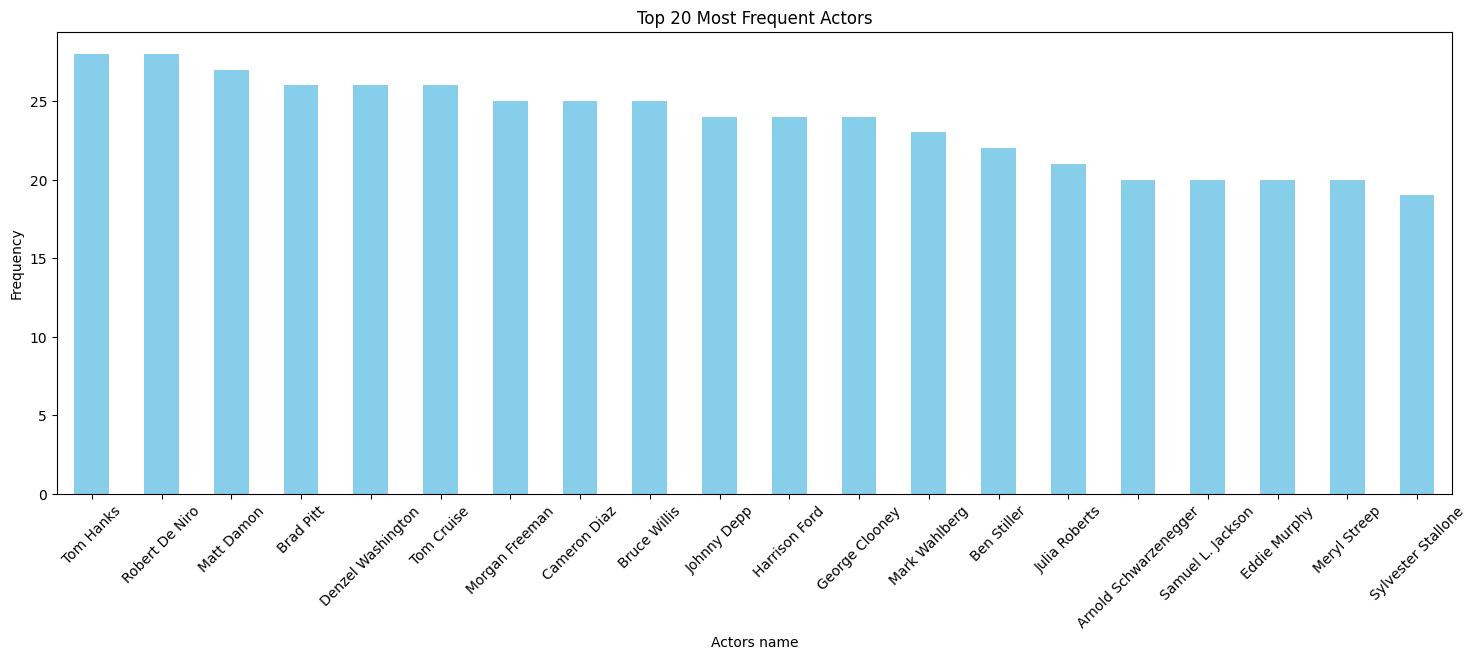

In [40]:
# Concatenate all three columns into a single Series
all_actors = pd.concat([df_profit['actor_1_name'], df_profit['actor_2_name'], df_profit['actor_3_name']])

# Count the occurrences of each actor
profit_actor_counts = all_actors.value_counts()

# Plot the top N most frequent actors
N = 20 # Change N to plot more or fewer actors
profit_top_names = profit_actor_counts.head(N)

plt.figure(figsize=(18, 6))
profit_top_names.plot(kind='bar', color='skyblue')
plt.title(f'Top {N} Most Frequent Actors')
plt.xlabel('Actors name')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [41]:
list(profit_top_names.index)

['Tom Hanks',
 'Robert De Niro',
 'Matt Damon',
 'Brad Pitt',
 'Denzel Washington',
 'Tom Cruise',
 'Morgan Freeman',
 'Cameron Diaz',
 'Bruce Willis',
 'Johnny Depp',
 'Harrison Ford',
 'George Clooney',
 'Mark Wahlberg',
 'Ben Stiller',
 'Julia Roberts',
 'Arnold Schwarzenegger',
 'Samuel L. Jackson',
 'Eddie Murphy',
 'Meryl Streep',
 'Sylvester Stallone']

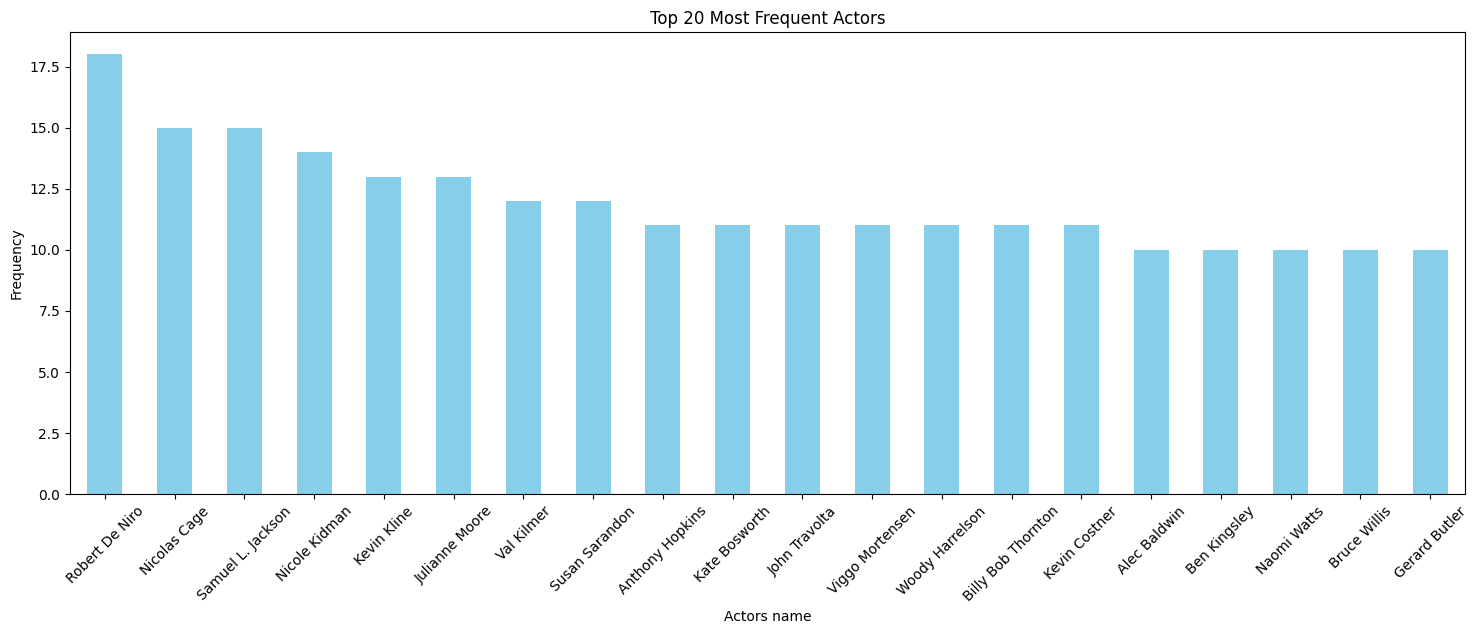

In [42]:
# Concatenate all three columns into a single Series
all_actors = pd.concat([df_no_profit['actor_1_name'], df_no_profit['actor_2_name'], df_no_profit['actor_3_name']])

# Count the occurrences of each actor
noprofit_actor_counts = all_actors.value_counts()

# Plot the top N most frequent actors
N = 20  # Change N to plot more or fewer actors
noprofit_top_names = noprofit_actor_counts.head(N)

plt.figure(figsize=(18, 6))
noprofit_top_names.plot(kind='bar', color='skyblue')
plt.title(f'Top {N} Most Frequent Actors')
plt.xlabel('Actors name')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [43]:
def make_top_actors(actors_list):
    for actor in actors_list:
        if actor in list(profit_top_names.index): # and actor not in list(noprofit_top_names.index):
            return 1
    return 0

In [44]:
make_top_actors(actors_list=['Shane Carruth', 'David Sullivan', 'Robert De Niro'])

1

In [45]:
df_preprocessed['top actors'] = df_preprocessed['actor_list'].apply(make_top_actors)

In [46]:
df_preprocessed['top actors'].value_counts()

top actors
0    4261
1     542
Name: count, dtype: int64

### Directors Preprocessing

#### Separating Data by Profitability
1. **Separating Data:** We separate the dataset into two subsets based on profitability: movies with profit and movies without profit.

#### Analyzing Top Directors
2. **Counting Director Occurrences:** We count the occurrences of each director in both profit and non-profit subsets.

3. **Plotting Top Directors:** We plot the top N most frequent directors for both profit and non-profit subsets to visualize their distribution.

4. **Identifying Top Directors:** We define a function, 'top_director()', to identify whether a director belongs to the top directors list based on their occurrence in the top directors list for profitable movies.

5. **Applying Top Directors Classification:** We apply the 'top_director()' function to each movie's director and create a new binary column, 'top_director', indicating whether the movie is directed by one of the top directors.

These preprocessing steps help in analyzing the impact of directors on a movie's profitability and categorizing movies based on the presence of top directors.


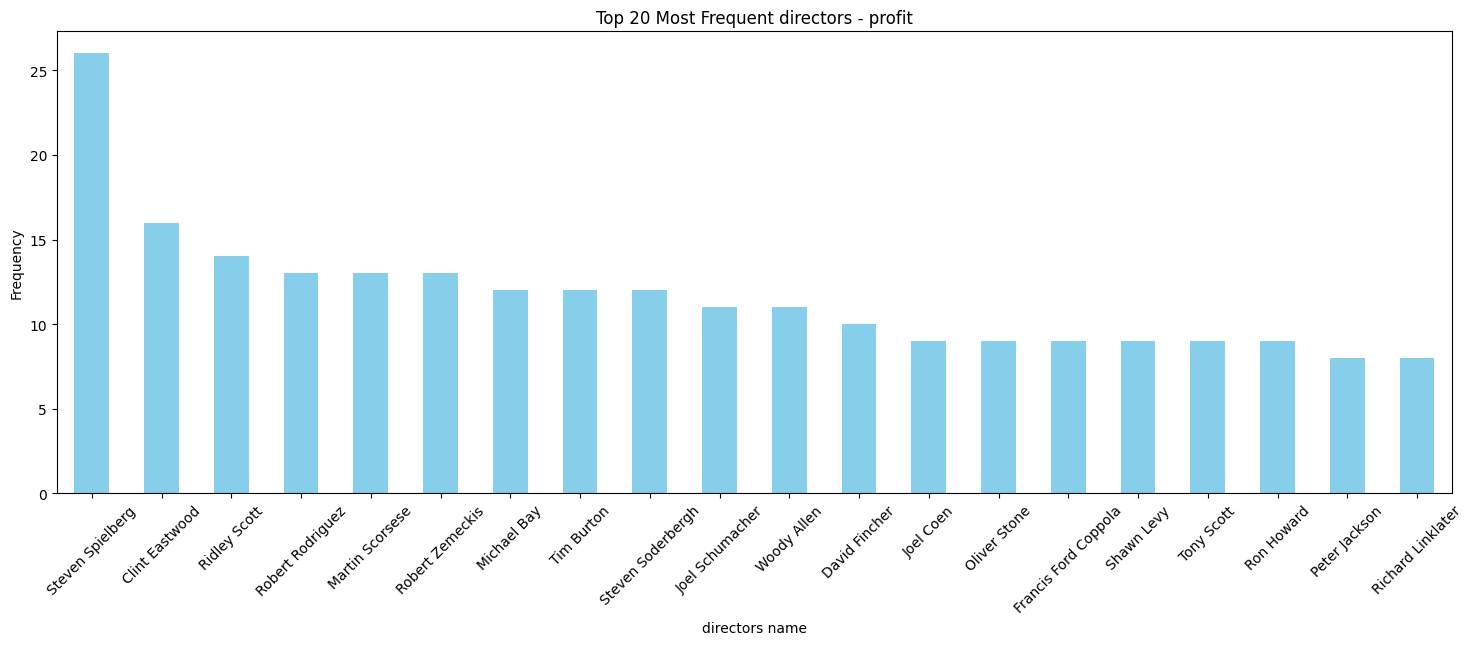

In [47]:
# Count the occurrences of each director
profit_director_counts = df_profit['director_name'].value_counts()

# Plot the top N most frequent actors
N = 20  # Change N to plot more or fewer actors
profit_top_names = profit_director_counts.head(N)

plt.figure(figsize=(18, 6))
profit_top_names.plot(kind='bar', color='skyblue')
plt.title(f'Top {N} Most Frequent directors - profit')
plt.xlabel('directors name')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

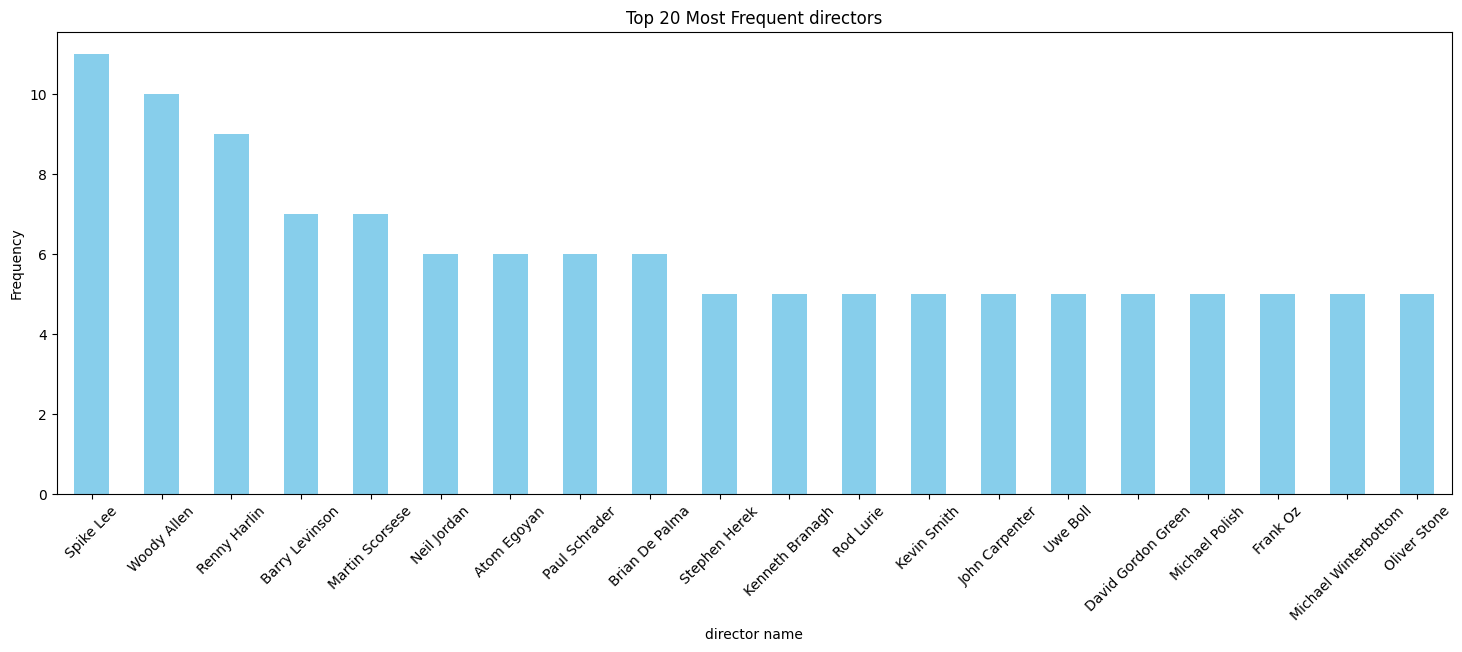

In [48]:
# Count the occurrences of each director
noprofit_director_counts = df_no_profit['director_name'].value_counts()

# Plot the top N most frequent actors
N = 20  # Change N to plot more or fewer actors
noprofit_top_names = noprofit_director_counts.head(N)

plt.figure(figsize=(18, 6))
noprofit_top_names.plot(kind='bar', color='skyblue')
plt.title(f'Top {N} Most Frequent directors')
plt.xlabel('director name')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [49]:
def top_director(director):

    if director in list(profit_top_names.index): # and director not in list(noprofit_top_names.index):
        return 1
    else:
        return 0

In [50]:
top_director(director='Shawn Levy')

1

In [51]:
df_preprocessed['top_director'] = df_preprocessed['director_name'].apply(top_director)

In [52]:
df_preprocessed['top_director'] .value_counts()

top_director
0    4513
1     290
Name: count, dtype: int64

### Language Preprocessing

#### Handling Missing Values
1. **Counting NaN Values:** We begin by counting the number of missing values in the 'language' column using the `count_nan_values()` function.

2. **Dropping Rows with Missing Values:** We drop rows with missing values in the 'language' column using the `dropna()` function to ensure that only movies with language information are retained in the dataset.

#### Summarizing Language Information
3. **Summarizing Language Data:** We create a new column, 'language_summarized', to summarize the language information. If the language is English, it is categorized as 'English'; otherwise, it is categorized as 'Not English'.

4. **Counting Summarized Language:** We count the occurrences of each summarized language category to understand the distribution of English and non-English movies in the dataset.

These preprocessing steps help in handling missing values and summarizing language information for further analysis or modeling purposes.


In [53]:
count_nan_values(df_preprocessed, 'language')

Number of NaN values in 'language': 86


In [54]:
df_preprocessed = df_preprocessed.dropna(subset=['language'])

In [55]:
df_preprocessed['language'].value_counts()

language
English             4102
Français             108
Español               84
Deutsch               61
العربية               33
普通话                   32
Italiano              32
Pусский               31
Český                 30
广州话 / 廣州話             28
日本語                   23
हिन्दी                22
Português             17
Dansk                 12
                      12
Latin                  8
한국어/조선말                8
Nederlands             6
עִבְרִית               6
Afrikaans              5
svenska                5
ελληνικά               5
Norsk                  4
Română                 4
Magyar                 4
ภาษาไทย                4
Polski                 3
فارسی                  3
Kiswahili              3
Український            2
தமிழ்                  2
No Language            2
Tiếng Việt             2
Gaeilge                1
اردو                   1
Bahasa indonesia       1
??????                 1
Srpski                 1
Íslenska               1
Eesti           

In [56]:
df_preprocessed['language_summarized'] = df_preprocessed['language'].apply(lambda x: 'English' if x == 'English' else 'Not English')


In [57]:
df_preprocessed['language_summarized'].value_counts()

language_summarized
English        4102
Not English     615
Name: count, dtype: int64

### Vote Average Preprocessing

#### Handling Missing Values
1. **Counting NaN Values:** We begin by counting the number of missing values in the 'vote_average' column using the `count_nan_values()` function to assess the completeness of the data.

2. **Handling Outliers:** We check for outliers in the 'vote_average' column by examining values that are less than 0 or greater than 10. Any outliers found are evaluated for potential correction or removal from the dataset.

#### Categorizing Vote Averages
3. **Defining Quartile Thresholds:** We define quartile thresholds to categorize the 'vote_average' values into different groups based on their distribution in the dataset. Quartiles are calculated to ensure an even distribution of data points across categories.

4. **Categorizing Vote Averages:** Using the quartile thresholds, we categorize the 'vote_average' values into four categories: 'not_popular', 'below_avg', 'average', and 'popular'. This categorization helps in understanding the popularity levels of movies based on their average ratings.

#### Assessing Categorized Data
5. **Counting Categorized Values:** We count the occurrences of each category in the 'vote_average_categorized' column to assess the distribution of movies across popularity levels.

6. **Handling Missing Values in Categories:** Finally, we check for any missing values in the categorized column to ensure completeness of the data after categorization.

These preprocessing steps help in organizing and categorizing the 'vote_average' feature to facilitate analysis and interpretation of movie popularity based on average ratings.


In [80]:
count_nan_values(df_preprocessed, 'vote_average')

Number of NaN values in 'vote_average': 0


In [81]:
df_preprocessed[df_preprocessed['vote_average'] < 0 ].shape

(0, 47)

In [82]:
df_preprocessed[df_preprocessed['vote_average'] > 10 ].shape

(0, 47)

In [83]:
# Define quartile thresholds for categorization
thresholds = [df_preprocessed['vote_average'].quantile(q) for q in [0, 0.25, 0.5, 0.75, 1]]
thresholds[0] = thresholds[0] - 0.001
thresholds[-1] = thresholds[-1] + 0.001

# Define labels for categories
labels = ['not_popular', 'below_avg', 'average', 'popular']

# Categorize 'vote_average'
df_preprocessed['vote_average_categorized'] = pd.cut(df_preprocessed['vote_average'], bins=thresholds, labels=labels)

# Display the categorized data
df_preprocessed['vote_average_categorized'].value_counts()

vote_average_categorized
not_popular    1240
average        1200
below_avg      1139
popular        1138
Name: count, dtype: int64

In [84]:
count_nan_values(df_preprocessed, 'vote_average_categorized')

Number of NaN values in 'vote_average_categorized': 0


### popularity

In [78]:
# Check for missing values
count_nan_values(df_preprocessed, 'popularity')

Number of NaN values in 'popularity': 0


In [79]:
# remove outlire

### plot_keywords

In [85]:
df_preprocessed['plot_keywords'][49]

'based on novel|infidelity|obsession|hope|3d'

In [83]:
def keywords_to_list(keywords):
    replaced_keywords = keywords.replace('|', ' ')
    return replaced_keywords.split(" ")

df_preprocessed['plot_keywords_list'] = df_preprocessed['plot_keywords'].apply(keywords_to_list)

In [84]:
df_preprocessed['plot_keywords'][49]

'based on novel|infidelity|obsession|hope|3d'

In [85]:
df_preprocessed['plot_keywords_list'][3]

['dc',
 'comics',
 'crime',
 'fighter',
 'terrorist',
 'secret',
 'identity',
 'burglar',
 'hostage',
 'drama',
 'time',
 'bomb',
 'gotham',
 'city',
 'vigilante',
 'cover-up',
 'superhero',
 'villainess',
 'tragic',
 'hero',
 'terrorism',
 'destruction',
 'catwoman',
 'cat',
 'burglar',
 'imax',
 'flood',
 'criminal',
 'underworld',
 'batman']

In [86]:
## save dataframe

In [86]:
df_preprocessed.to_csv('df_preprocessed_2.csv', index=False)

# Preprocessing text features
### TD-IDF

In [88]:
# import nltk
# nltk.download('wordnet')


In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import re

In [93]:
documents = df_preprocessed['overview']

In [94]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Additional stop words
custom_stopwords = set(stopwords.words('english')).union(ENGLISH_STOP_WORDS)

# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = text.split()
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Remove stop words
    tokens = [token for token in tokens if token not in custom_stopwords]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

# Preprocess each document
preprocessed_documents = [preprocess_text(doc) for doc in documents]

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=100) # max_features=100

# Fit the vectorizer to the preprocessed data and transform the documents into a feature matrix
overview_features = vectorizer.fit_transform(preprocessed_documents)

# Convert the extracted features to a DataFrame
overview_features_df = pd.DataFrame(overview_features.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the features DataFrame with the original DataFrame
df_with_features = pd.concat([df_preprocessed, overview_features_df], axis=1)

In [95]:
df_with_features.to_csv('df_with_features.csv', index=False)

In [97]:
# Get the feature names (tokens) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the TF-IDF matrix
tfidf_matrix = overview_features.toarray()

# Calculate the mean TF-IDF score for each token across all documents
mean_tfidf_scores = np.mean(tfidf_matrix, axis=0)

# Create a dictionary mapping each token to its mean TF-IDF score
token_tfidf_scores = dict(zip(feature_names, mean_tfidf_scores))

# Sort the tokens by their mean TF-IDF scores
sorted_tokens = sorted(token_tfidf_scores.items(), key=lambda x: x[1], reverse=True)

# Print the sorted tokens with their mean TF-IDF scores
for token, score in sorted_tokens:
    print(f"Token: {token}, Mean TF-IDF Score: {score}")

Token: life, Mean TF-IDF Score: 0.062348919696771095
Token: ha, Mean TF-IDF Score: 0.05481374167011756
Token: world, Mean TF-IDF Score: 0.04645408480777507
Token: new, Mean TF-IDF Score: 0.04593413895732617
Token: young, Mean TF-IDF Score: 0.039894187662803525
Token: man, Mean TF-IDF Score: 0.039682049799094475
Token: family, Mean TF-IDF Score: 0.037781651479074675
Token: friend, Mean TF-IDF Score: 0.03647699136541858
Token: story, Mean TF-IDF Score: 0.0343838818416035
Token: love, Mean TF-IDF Score: 0.03300778955510434
Token: year, Mean TF-IDF Score: 0.032331806637358775
Token: woman, Mean TF-IDF Score: 0.029087496214908807
Token: way, Mean TF-IDF Score: 0.026773988622094052
Token: set, Mean TF-IDF Score: 0.02645904173558196
Token: war, Mean TF-IDF Score: 0.02625793585957542
Token: time, Mean TF-IDF Score: 0.02610760066691941
Token: help, Mean TF-IDF Score: 0.0261040354234608
Token: father, Mean TF-IDF Score: 0.02524596094550425
Token: team, Mean TF-IDF Score: 0.02476629759147334
Toke

In [ ]:
sorted_tokens

In [ ]:
df_preprocessed.head()

In [ ]:
sorted_tokens[i][0]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Sample text data
documents = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer to the data and transform the documents into a feature matrix
X = vectorizer.fit_transform(documents)

# Print the feature matrix
print(X.toarray())

# Print the vocabulary (mapping of terms to feature indices)
print(vectorizer.vocabulary_)


In [ ]:
# Print the vocabulary (mapping of terms to feature indices) and their counts
vocab = vectorizer.vocabulary_
for word, idx in vocab.items():
    print(f"Word: {word}, Count: {X[:, idx].sum()}")

In [ ]:
# Sample text data
documents = [
    ["This", "is", "the", "first", "document."],
    ["This", "document", "is", "the", "second", "document."],
    ["And", "this", "is", "the", "third", "one."],
    ["Is", "this", "the", "first", "document?"],
]

# Convert the list of lists into list of strings
documents = [" ".join(doc) for doc in documents]

# Create a CountVectorizer object with n-gram range from unigrams to trigrams
vectorizer = CountVectorizer(ngram_range=(1, 3))

# Fit the vectorizer to the data and transform the documents into a feature matrix
X = vectorizer.fit_transform(documents)

# Print the feature matrix
print(X.toarray())

# Print the vocabulary (mapping of terms to feature indices)
print(vectorizer.vocabulary_)

In [ ]:
# Print the vocabulary (mapping of terms to feature indices) and their counts
vocab = vectorizer.vocabulary_
for word, idx in vocab.items():
    print(f"Word: {word}, Count: {X[:, idx].sum()}")

In [ ]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Sample text data
documents = [
    "Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language.",
    "NLP techniques allow computers to process and understand human language in a meaningful way.",
    "Common NLP tasks include text classification, sentiment analysis, and machine translation.",
    "Stop words such as 'the', 'is', 'and', etc., are often removed during NLP preprocessing to focus on meaningful content.",
]

# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    text = ' '.join(word for word in text.split() if word not in ENGLISH_STOP_WORDS)
    return text

# Preprocess each document
preprocessed_documents = [preprocess_text(doc) for doc in documents]

# Create a CountVectorizer object with n-gram range from unigrams to trigrams
vectorizer = CountVectorizer(ngram_range=(1, 3))

# Fit the vectorizer to the preprocessed data and transform the documents into a feature matrix
X = vectorizer.fit_transform(preprocessed_documents)

# Print the feature matrix
print(X.toarray())

# Print the vocabulary (mapping of terms to feature indices)
print(vectorizer.vocabulary_)


In [ ]:
preprocessed_documents

In [ ]:
import numpy as np




In [ ]:
type(df_preprocessed['overview'][0])

In [ ]:
preprocess_text(df_preprocessed['overview'][0])

In [ ]:
for i in df_preprocessed['overview']:
    if type(i) != str:
        print(i)
        print(type(i))

In [ ]:
feature_names